In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

### 1. Read the training data

In [2]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["Rock", "Hiphop", "R&B", "Folk", "Indie"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


Rock
Hiphop
R&B
Folk
Indie


In [3]:
tracks_df['genre'].value_counts()

rock      2134
folk      1865
indie     1774
hiphop    1548
rnb       1508
Name: genre, dtype: int64

In [4]:
#check shape
playlist_df.shape, tracks_df.shape

((342, 7), (8829, 22))

In [5]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [6]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [7]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8829, 22)

In [8]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

8482

In [9]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8482, 22)

<AxesSubplot:>

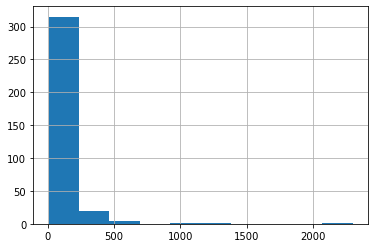

In [10]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

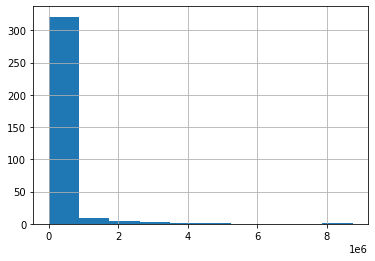

In [11]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [12]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

rock      0.251592
folk      0.218934
hiphop    0.182268
indie     0.178731
rnb       0.168474
Name: genre, dtype: float64

### 2. Refine the training data

In [13]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWXRqgorJj26U,Rock Classics,145,spotify,Spotify,8743130,rock
1,37i9dQZF1DXcF6B6QPhFDv,Rock This,50,spotify,Spotify,4490659,rock
2,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,150,spotify,Spotify,4111532,rock
3,37i9dQZF1DWYN0zdqzbEwl,Rock en Español,60,spotify,Spotify,3829864,rock
4,37i9dQZF1DX3oM43CtKnRV,00s Rock Anthems,50,spotify,Spotify,3474724,rock


In [14]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

rock      652
hiphop    622
folk      551
indie     385
rnb       283
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [15]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [16]:


tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    2493.000000
mean        0.780520
std         0.092970
min         0.000000
25%         0.737415
50%         0.798792
75%         0.844682
max         1.000000
Name: loudness, dtype: float64

In [17]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    2493.000000
mean        0.437393
std         0.179644
min         0.000000
25%         0.288169
50%         0.421637
75%         0.556355
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [18]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [19]:
tracks_df['genre'].value_counts()

rock      652
hiphop    622
folk      551
indie     385
rnb       283
Name: genre, dtype: int64

In [20]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,0hCB0YR03f6AmQaHbwWDe8,Whole Lotta Love - 1990 Remaster,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,70lQYZtypdCALtFVlQAcvx,333893,1969-10-22,75,0.412,0.902,...,0.04840,0.131000,0.4050,0.422,0.256937,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,5.564883,4
1,2aoo2jlRnM3A0NyLQqMN2f,All Along the Watchtower,776Uo845nYHJpNaStv1Ds4,Jimi Hendrix,5z090LQztiqh13wYspQvKQ,240800,1968-10-25,76,0.438,0.805,...,0.00255,0.000057,0.0842,0.564,0.396949,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.013333,4
2,08mG3Y1vljYA6bvDt4Wqkj,Back In Black,711MCceyCBcFnzjGY4Q7Un,AC/DC,6mUdeDZCsExyJLMdAfDuwh,255493,1980-07-25,82,0.310,0.700,...,0.01100,0.009650,0.0828,0.763,0.844340,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.258217,4
3,1RJeiAIwR9pZBgJA8ndZLL,"Paint It, Black - Mono",22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,5nKpMsduwp5xqCKq2IbSKv,204480,1966-01-01,68,0.505,0.836,...,0.01030,0.077100,0.2950,0.764,0.673340,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,3.408000,4
4,66lOpKgTyFjOrac4S1s94g,Rebel Rebel - 1999 Remaster,0oSGxfWSnnOXhD2fKuz2Gy,David Bowie,6JxxRxzjsOTtKVie29FTt2,269360,1974-04-24,0,0.676,0.920,...,0.00101,0.000009,0.2480,0.624,0.474883,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.489333,4


In [21]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{4: 'rock', 1: 'hiphop', 3: 'rnb', 0: 'folk', 2: 'indie'}

## 4. Train a KNN model

In [22]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model

In [23]:
#Select audio features to use for the model
feature_cols =  ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                'liveness',\
                'valence',\
                'tempo'\
                ]
results_optimal_k = []

kfolds= [4,5,8,10]
for col in feature_cols:
    if col != 'danceability':
        for d in kfolds:
            print('\nTuning kNN classification model with K-Fold=%d...' % d)
            # create feature matrix (X)
            duo = []
            duo.append(col)
            duo.append('danceability')
            X = tracks_df[duo]
            y = tracks_df['genre_id']
    
            # creating training set, test set and checking shapes 
            X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
            #print("Shape of X_Train:"+str(X_train.shape))
            #print("Shape of y_Train:"+str(Y_train.shape))
            #print("Shape of X_Test:"+str(X_test.shape))
            #print("Shape of y_Test:"+str(Y_test.shape))
            
            #train model
            cv_scores = []
            neighbors=np.arange(2,51)
            #print('Finding best k...')
            
            #Perform KNN using K= [1..50] and validate using k-fold k = 5
            for k in neighbors:
                #print('Fitting for k=%d' % k)
                knn = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
                cv_scores.append(scores.mean())
            
            # changeto misclassification error
            mse = [1 - x for x in cv_scores]
        
            # determining best k
            optimal_k = neighbors[mse.index(min(mse))]
            results_optimal_k.append(optimal_k)
            
            knn_optimal = KNeighborsClassifier(n_neighbors=k)
            #knn_optimal.fit(X, y)
            # plot misclassification error vs k
            #plt.plot(neighbors, mse)
            #plt.xlabel("Number of Neighbors K")
            #plt.ylabel("Misclassification Error")
            #plt.show()
            
            print(col + " and danceability feature the optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))



Tuning kNN classification model with K-Fold=4...
energy and danceability feature the optimal number of neighbors is 38 with score 47%

Tuning kNN classification model with K-Fold=5...
energy and danceability feature the optimal number of neighbors is 24 with score 48%

Tuning kNN classification model with K-Fold=8...
energy and danceability feature the optimal number of neighbors is 47 with score 47%

Tuning kNN classification model with K-Fold=10...
energy and danceability feature the optimal number of neighbors is 47 with score 48%

Tuning kNN classification model with K-Fold=4...
loudness and danceability feature the optimal number of neighbors is 32 with score 45%

Tuning kNN classification model with K-Fold=5...
loudness and danceability feature the optimal number of neighbors is 31 with score 44%

Tuning kNN classification model with K-Fold=8...
loudness and danceability feature the optimal number of neighbors is 40 with score 45%

Tuning kNN classification model with K-Fold=10.

In [36]:
#Select audio features to use for the model
feature_cols =  ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
                ]
results_optimal_k = []

kfolds= [4,5,8,10]
for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    #print("Shape of X_Train:"+str(X_train.shape))
    #print("Shape of y_Train:"+str(Y_train.shape))
    #print("Shape of X_Test:"+str(X_test.shape))
    #print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    #knn_optimal.fit(X, y)
    # plot misclassification error vs k
    #plt.plot(neighbors, mse)
    #plt.xlabel("Number of Neighbors K")
    #plt.ylabel("Misclassification Error")
    #plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))



Tuning kNN classification model with K-Fold=4...
Finding best k...
The optimal number of neighbors is 22 with score 55%

Tuning kNN classification model with K-Fold=5...
Finding best k...
The optimal number of neighbors is 46 with score 56%

Tuning kNN classification model with K-Fold=8...
Finding best k...
The optimal number of neighbors is 49 with score 56%

Tuning kNN classification model with K-Fold=10...
Finding best k...
The optimal number of neighbors is 50 with score 55%


In [37]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[22, 46, 49, 50]

### 5.  Spotify Chart Classifier

In [38]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2,-6.209,1,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,88,0.358,0.557,10,-7.398,1,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,87,0.748,0.524,8,-5.599,1,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,0,-8.821,1,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,1,0.783,0.623,7,-6.126,1,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [39]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [40]:
#Predict genres of the spotify charts
'''
feature_cols = ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
               ]
'''
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 50


In [41]:
#explore genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_folk_prob,predicted_hiphop_prob,predicted_indie_prob,predicted_rnb_prob,predicted_rock_prob
1649,1jo3TwNGCXfNdB5uba3ZVv,Killshot,7dGJo4pcD2V6oG8kP0tJRR,Eminem,0RejlT9bmqcXGrqMaJRos0,253579,2018-09-19,75,0.893,0.651,...,0.600,0.327736,1,hiphop,0.96,0.0,0.96,0.02,0.02,0.00
1232,6n4U3TlzUGhdSFbUUhTvLP,Walk It Talk It,6oMuImdp5ZcFhWP0ESe6mG,Migos,7fd7SEK25VS3gJAUgSwL6y,276147,2018-01-26,78,0.907,0.633,...,0.395,0.574349,1,hiphop,0.96,0.0,0.96,0.00,0.04,0.00
2940,4Oun2ylbjFKMPTiaSbbCih,WAP (feat. Megan Thee Stallion),4kYSro6naA4h99UJvo89HB,Cardi B,2ogiazbrNEx0kQHGl5ZBTQ,187541,2020-08-07,95,0.935,0.454,...,0.357,0.495336,1,hiphop,0.96,0.0,0.96,0.00,0.04,0.00
2138,6dPyzkyZwoj9LqjQXOFdVv,Press,4kYSro6naA4h99UJvo89HB,Cardi B,4OYI54WJJQRkCG4FVmIuTZ,143791,2019-05-31,70,0.888,0.525,...,0.243,0.500935,1,hiphop,0.96,0.0,0.96,0.00,0.04,0.00
138,4Km5HrUvYTaSUfiSGPJeQR,Bad and Boujee (feat. Lil Uzi Vert),6oMuImdp5ZcFhWP0ESe6mG,Migos,2AvupjUeMnSffKEV05x222,343150,2017-01-27,78,0.927,0.665,...,0.175,0.458435,1,hiphop,0.96,0.0,0.96,0.00,0.02,0.02


Check out tracks with highest assigned probability

In [42]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
1649,Eminem,Killshot,hiphop,0.96
1232,Migos,Walk It Talk It,hiphop,0.96
2940,Cardi B,WAP (feat. Megan Thee Stallion),hiphop,0.96
2138,Cardi B,Press,hiphop,0.96
138,Migos,Bad and Boujee (feat. Lil Uzi Vert),hiphop,0.96
1329,Oasis,Wonderwall - Remastered,rock,0.90
3105,TOMORROW X TOGETHER,Ghosting,rock,0.86
660,Linkin Park,Somewhere I Belong,rock,0.86
410,Coldplay,Viva La Vida - Live from Spotify London,rock,0.84
700,LANY,Dumb Stuff,rock,0.84


View histogram of predicted genre probabilities

<AxesSubplot:>

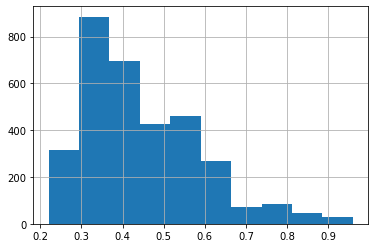

In [43]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [44]:
chart_tracks_df['predicted_genre'].value_counts()

rock      1199
folk      1066
hiphop     746
indie      172
rnb        101
Name: predicted_genre, dtype: int64

### 5.  Artist Classifier

In [45]:
artist = 'Nyoy Volante'

In [55]:
artist_tracks_df = pd.read_csv('data/'+artist.lower()+'_album_tracks_data.csv')
artist_tracks_df = artist_tracks_df[artist_tracks_df['artist_name']==artist]

In [56]:
#Predict genres of the spotify charts
'''
feature_cols = ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
               ]
'''
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

artist_tracks_df['predicted_genre_id'] = artist_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
artist_tracks_df['predicted_genre'] = artist_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
artist_tracks_df['predicted_genre_prob'] = artist_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
artist_tracks_df['all_genre_prob'] = artist_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 50


In [57]:
#explore genre probabilities into separate columns
artist_predicted_genre_prob = pd.DataFrame(artist_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
artist_predicted_genre_prob['track_id'] = artist_tracks_df['track_id']
artist_tracks_df = pd.merge(artist_tracks_df,artist_predicted_genre_prob, how='left', on='track_id')
artist_tracks_df = artist_tracks_df.drop(columns='all_genre_prob')
artist_tracks_df = artist_tracks_df.sort_values('predicted_genre_prob', ascending=False)
artist_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,playlist_id,playlist_name,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_folk_prob,predicted_hiphop_prob,predicted_indie_prob,predicted_rnb_prob,predicted_rock_prob
44,3MYfcVRTLqo7t3ra4DqFRn,Ama Namin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,1maIgsJ7htTqCDrhe8aucE,113640,2008-08-09,10,0.000,0.118,...,3MYfcVRTLqo7t3ra4DqFRn,3MYfcVRTLqo7t3ra4DqFRn,0,folk,0.72,0.72,0.02,0.24,0.00,0.02
0,2pAFgfaNVioQGhC0jhtcsG,Ipagpatawad Mo,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,5jzfPxlD5UD4Aw3cEnelcC,239333,2012-01-01,29,0.622,0.522,...,2pAFgfaNVioQGhC0jhtcsG,2pAFgfaNVioQGhC0jhtcsG,4,rock,0.26,0.22,0.24,0.16,0.12,0.26
55,1vjdKdp3P8QKfbrb0eUljJ,The One You Love,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,2A48roBpFpFjatWtksmsQE,276893,2008-05-06,29,0.556,0.301,...,1vjdKdp3P8QKfbrb0eUljJ,1vjdKdp3P8QKfbrb0eUljJ,4,rock,0.26,0.22,0.24,0.16,0.12,0.26
62,0PhKUUh0XzAHev6opemDtH,'Di Na Mapigilan,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,263186,2002-06-01,1,0.567,0.520,...,0PhKUUh0XzAHev6opemDtH,0PhKUUh0XzAHev6opemDtH,4,rock,0.26,0.22,0.24,0.16,0.12,0.26
61,3RYkG7WmnRK6HSejhCo7jw,Ikaw Lang Para Sa Akin,3pTaNQJ7TAU4yL7KEZp5sF,Nyoy Volante,4EQ7a4ztLVN5OUgxJJVIxY,259746,2002-06-01,8,0.394,0.561,...,3RYkG7WmnRK6HSejhCo7jw,3RYkG7WmnRK6HSejhCo7jw,4,rock,0.26,0.22,0.24,0.16,0.12,0.26


Check out tracks with highest assigned probability

In [58]:
artist_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
44,Nyoy Volante,Ama Namin,folk,0.72
0,Nyoy Volante,Ipagpatawad Mo,rock,0.26
55,Nyoy Volante,The One You Love,rock,0.26
62,Nyoy Volante,'Di Na Mapigilan,rock,0.26
61,Nyoy Volante,Ikaw Lang Para Sa Akin,rock,0.26
60,Nyoy Volante,Be My Lady,rock,0.26
56,Nyoy Volante,Dreaming of You,hiphop,0.26
52,Nyoy Volante,What's Forever For,hiphop,0.26
47,Nyoy Volante,You're Not Mine,hiphop,0.26
43,Nyoy Volante,Baby Stay,hiphop,0.26


<AxesSubplot:>

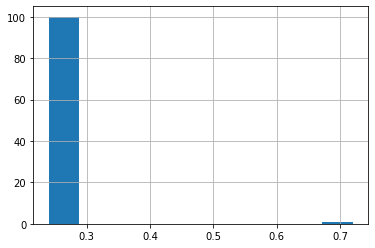

In [59]:
artist_tracks_df['predicted_genre_prob'].hist()

In [60]:
artist_tracks_df['predicted_genre'].value_counts()

rock      64
hiphop    34
folk       3
Name: predicted_genre, dtype: int64